## Setup

In [23]:
# Only required for google colab

from google.colab import drive
drive.mount('/content/drive')

!pip install livelossplot

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# perform the necessary imports

import pandas as pd
import numpy as np
import os
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import optimizers
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  
sns.set()
%matplotlib inline
from livelossplot import PlotLossesKeras

In [25]:
cd '/content/drive/My Drive'

/content/drive/My Drive


# Data Preparation & Analysis

In [0]:
# specify constants

image_location = './data/cropped_faces/'
processed_folder = './processed_data/cropped_faces/'
random_state = 3
train_size = 1000
test_size = 1000
valid_size = 500

In [0]:
feature_extractor = InceptionV3(weights='imagenet', include_top=False, pooling=None)
target_size = (299, 299)
features_folder = processed_folder + 'inceptionV3/'
# warning is due to changes in keras 2.2.0, we will go without the pooling layer so that we can Flatten with more data.

In [0]:
files = [name for name in os.listdir(image_location)]
def process_file_name(name):
    split_name = name.split('_')
    # in case we run into problems, just put None for all values so we drop it later
    return [name] + list(map(int, split_name[:3])) if len(split_name) == 4 else [name, None, None, None]

processed_files = [process_file_name(name) for name in files]
data = pd.DataFrame(columns=['Name', 'Age', 'Gender', 'Race'], data=processed_files).dropna()
targets = data['Age']
# let's see a some details about our data
data.describe()

,Age,Gender,Race
count,23705.000000,23705.000000,23705.000000
mean,33.300907,0.477283,1.269226
std,19.885708,0.499494,1.345638
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,0.000000,1.000000
75%,45.000000,1.000000,2.000000
max,116.000000,1.000000,4.000000


In [0]:
data.head()

,Name,Age,Gender,Race
0,9_1_2_20161219204347420.jpg.chip.jpg,9.0,1.0,2.0
1,36_0_1_20170117163203851.jpg.chip.jpg,36.0,0.0,1.0
2,86_1_0_20170120225751953.jpg.chip.jpg,86.0,1.0,0.0
3,26_1_0_20170116171048641.jpg.chip.jpg,26.0,1.0,0.0
4,1_1_2_20161219154612988.jpg.chip.jpg,1.0,1.0,2.0


In [0]:
train_data, valid_data, test_data = np.split(data.sample(n=train_size+valid_size+test_size, random_state=random_state), [train_size, train_size+valid_size])
train_targets, valid_targets, test_targets = train_data['Age'], valid_data['Age'], test_data['Age']

# cofnirm we got the sizes we aimed for
assert len(train_data) == train_size
assert len(valid_data) == valid_size
assert len(test_data) == test_size

In [0]:
def show_datset_distribution(data, title):
    # the chart looks better with proper names
    def add_label_data_for_chart(data):
        def convert_race(r):
            if r == 0:
                return 'White'
            if r == 1:
                return 'Black'
            if r == 2:
                return 'Asian'
            if r == 3:
                return 'Indian'
            if r == 4:
                return 'Other'
        data['Gender_Label'] = data['Gender'].apply(lambda g: 'Male' if g == 0 else 'Female')
        data['Race_Label'] = data['Race'].apply(lambda r: convert_race(r))
        return data
    # we don't want to modify the actual dataset
    data = data.copy()
    # add descriptive labels
    add_label_data_for_chart(data)
    # let's draw
    figure,ax=plt.subplots(1,3, figsize=(20,5))
    figure.suptitle(title, fontsize=16)
    data['Age'].plot(kind='hist', bins=30,title='Age distribution', ax=ax[0])
    ax[0].set_xlabel('Age')
    sns.catplot(x='Gender_Label', kind="count",  data=data, ax=ax[1], order=['Male', 'Female']);
    ax[1].set_title('Gender Distribution')
    ax[1].set_xlabel('Gender')
    sns.catplot(x='Race_Label', kind="count",  data=data, ax=ax[2], order=['White', 'Black', 'Asian', 'Indian', 'Other']);
    ax[2].set_title('Race Distribution')
    ax[2].set_xlabel('Race')
    plt.close(2)
    plt.close(3)
    None


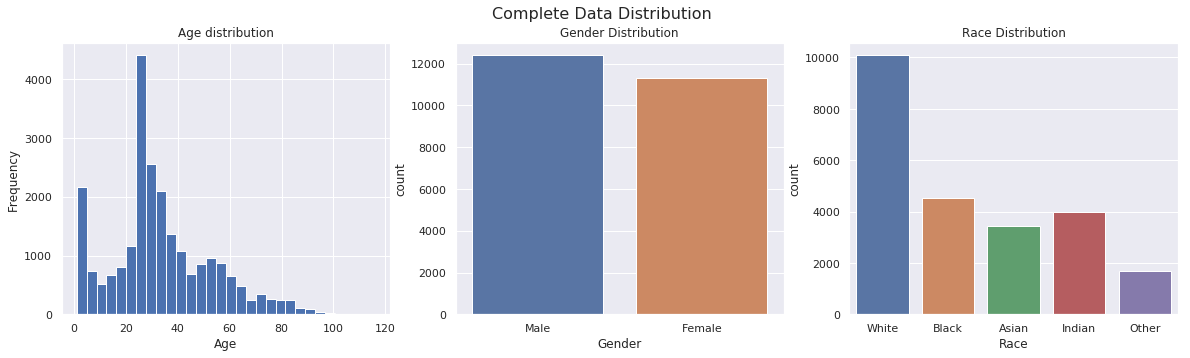

In [0]:
show_datset_distribution(data, 'Complete Data Distribution')

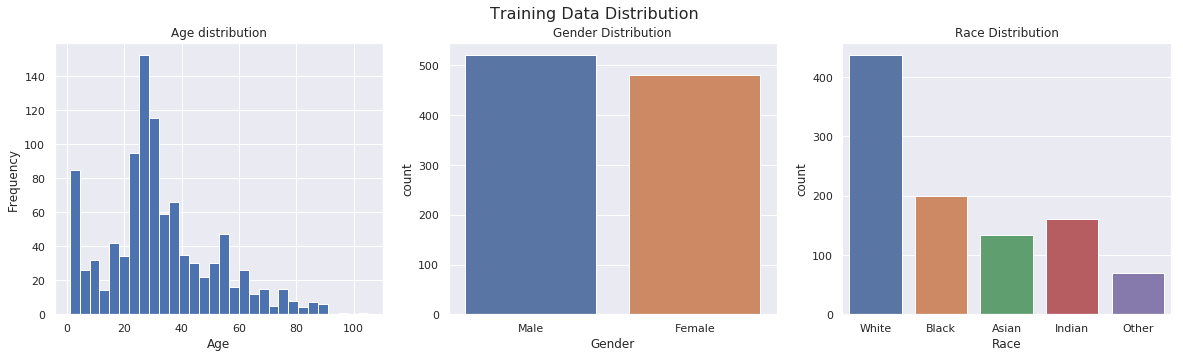

In [0]:
show_datset_distribution(train_data, 'Training Data Distribution')

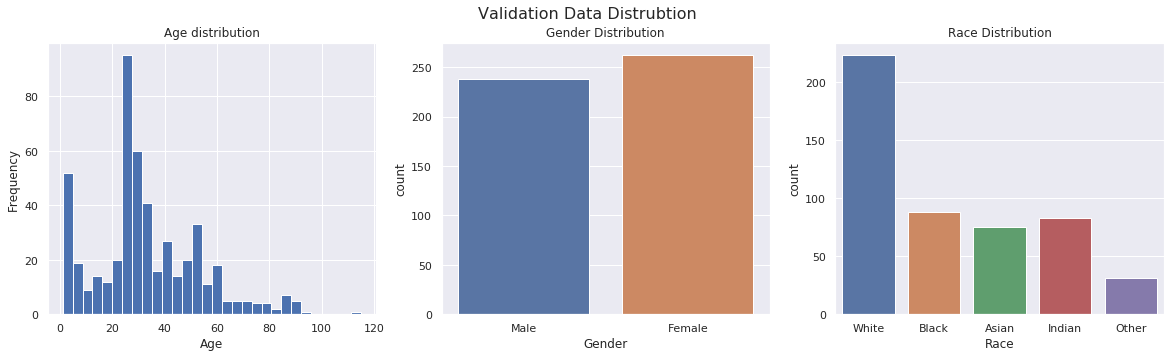

In [0]:
show_datset_distribution(valid_data, 'Validation Data Distrubtion')

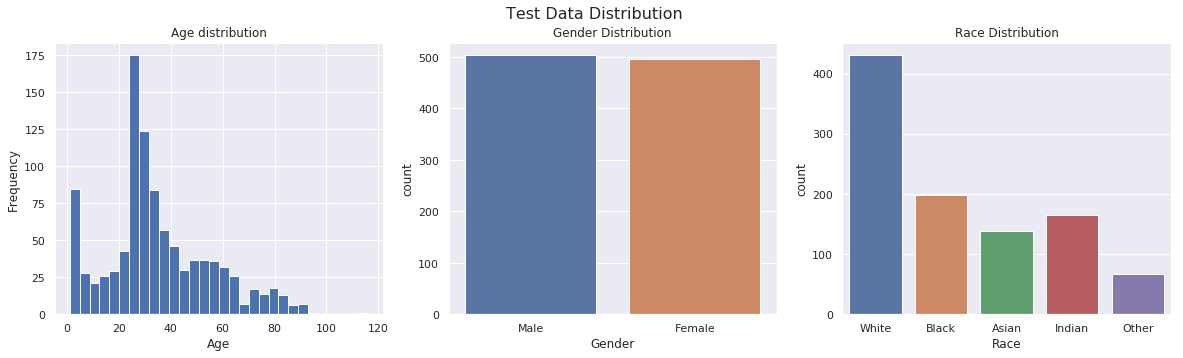

In [0]:
show_datset_distribution(test_data, 'Test Data Distribution')

In [0]:
# let's save the data, so we can use it later
data.to_csv(processed_folder + 'full_data.csv')
train_data.to_csv(processed_folder + 'train_data.csv')
valid_data.to_csv(processed_folder + 'valid_data.csv')
test_data.to_csv(processed_folder + 'test_data.csv')

In [0]:
# methods obtained from dog breed classifier project (with modification)
def path_to_tensor(file, target_size):
    img = image.load_img(file, target_size=target_size)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)
  
def paths_to_tensor(files, target_size):
    list_of_tensors = [path_to_tensor(file, target_size) for file in files]
    return np.vstack(list_of_tensors)

def extract_features(files, target_size):
    return feature_extractor.predict(preprocess_input(paths_to_tensor(files, target_size)))


In [0]:
def extract_features_for_dataset(data, file_prefix, target_size, save=True):
    # extract data features for given dataset
    data_features = extract_features(list(map(lambda name: image_location + name, data['Name'])), target_size)
    if save:
        np.save(features_folder + file_prefix + '_data_features', data_features)
    return data_features

In [13]:
train_data_features = extract_features_for_dataset(train_data, 'train', target_size)
train_data_features.shape

(1000, 8, 8, 2048)

In [14]:
valid_data_features = extract_features_for_dataset(valid_data, 'valid', target_size)
valid_data_features.shape

(500, 8, 8, 2048)

In [15]:
test_data_features = extract_features_for_dataset(test_data, 'test', target_size)
test_data_features.shape

(1000, 8, 8, 2048)

In [0]:
def load_input_features(features_folder):
    train_data_features = np.load(features_folder + 'train_data_features.npy')
    valid_data_features = np.load(features_folder + 'valid_data_features.npy')
    test_data_features = np.load(features_folder + 'test_data_features.npy')
    return train_data_features, valid_data_features, test_data_features

def load_data(processed_folder):
    train_data = pd.read_csv(processed_folder + 'train_data.csv')
    train_targets = train_data['Age']
    valid_data = pd.read_csv(processed_folder + 'valid_data.csv')
    valid_targets = valid_data['Age']
    test_data = pd.read_csv(processed_folder + 'test_data.csv')
    test_targets = test_data['Age']
    return train_data, train_targets, valid_data, valid_targets, test_data, test_targets

train_data_features, valid_data_features, test_data_features = load_input_features(features_folder)
train_data, train_targets, valid_data, valid_targets, test_data, test_targets = load_data(processed_folder)

In [0]:
# some methods to avoid repetition
def run_model(model, x=train_data_features, y=train_targets, x_val=valid_data_features, y_val=valid_targets):
  model.fit(x, y, validation_data=(x_val, y_val),
          epochs=100, batch_size=32, callbacks=[checkpointer, PlotLossesKeras()], verbose=1)

def evaluate_model(model, x=test_data_features, y=test_targets):
  metrics = model.evaluate(x=x, y=y)
  for metric in zip(model.metrics_names, metrics):
      print('{}: {}'.format(metric[0], metric[1]))

# Custom Metrics

In [0]:
def soft_accuracy_10(y_true, y_pred):
    return K.mean(abs(y_pred - y_true) < 10)
  
def soft_accuracy_5(y_true, y_pred):
    return K.mean(abs(y_pred - y_true) < 5)
  
def tilted_loss(y, f, q=.7):
  # code based on https://sachinruk.github.io/blog/Quantile-Regression/
  e = (y-f)
  return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

# Naive Benchmark

In [0]:
def save_base_tensor(data, file_location):
    # we save the tensor representing the iamge, we shall use this in our naive benchmark
    data_tensors = paths_to_tensor(list(map(lambda name: image_location + '/'+ name, data['Name'])), target_size)
    np.save(file_location, data_tensors)
    return data_tensors

In [0]:
naive_benchmark_folder = processed_folder + '/naive_benchmark/'
train_data_tensors = save_base_tensor(train_data, naive_benchmark_folder + 'train_data_tensors')
valid_data_tensors = save_base_tensor(valid_data, naive_benchmark_folder + 'valid_data_tensors')
test_data_tensors = save_base_tensor(test_data,  naive_benchmark_folder + 'test_data_tensors')
None

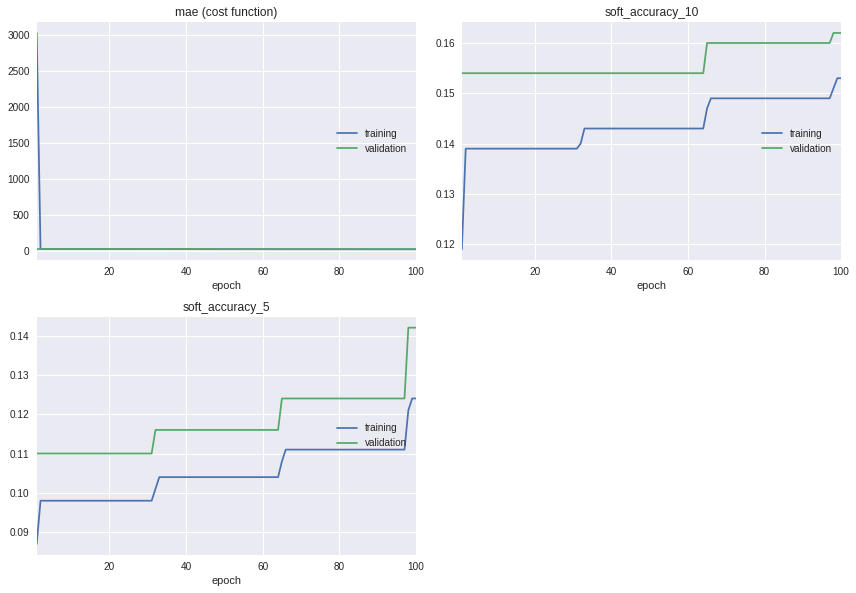

mae (cost function):
training   (min:   29.629, max: 3026.200, cur:   29.629)
validation (min:   30.273, max:   33.040, cur:   30.273)

soft_accuracy_10:
training   (min:    0.119, max:    0.153, cur:    0.153)
validation (min:    0.154, max:    0.162, cur:    0.162)

soft_accuracy_5:
training   (min:    0.087, max:    0.124, cur:    0.124)
validation (min:    0.110, max:    0.142, cur:    0.142)


In [38]:
def naive_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = naive_model(train_data_tensors.shape[1:])      
model.summary()

checkpointer = ModelCheckpoint(filepath=naive_benchmark_folder + 'weights.best.hdf5', 
                               verbose=1, save_best_only=True)

run_model(model, x=train_data_tensors, x_val=valid_data_tensors)

In [39]:
evaluate_model(model, x=test_data_tensors)

1000/1000 [==============================] - 3s 3ms/step
loss: 31.947462646484375
soft_accuracy_10: 0.136
soft_accuracy_5: 0.113


# Version 1

In [40]:
def cnn_v1_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v1_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v1_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                2621460   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 2,621,481
Trainable params: 2,621,481
Non-trainable params: 0
_________________________________________________________________


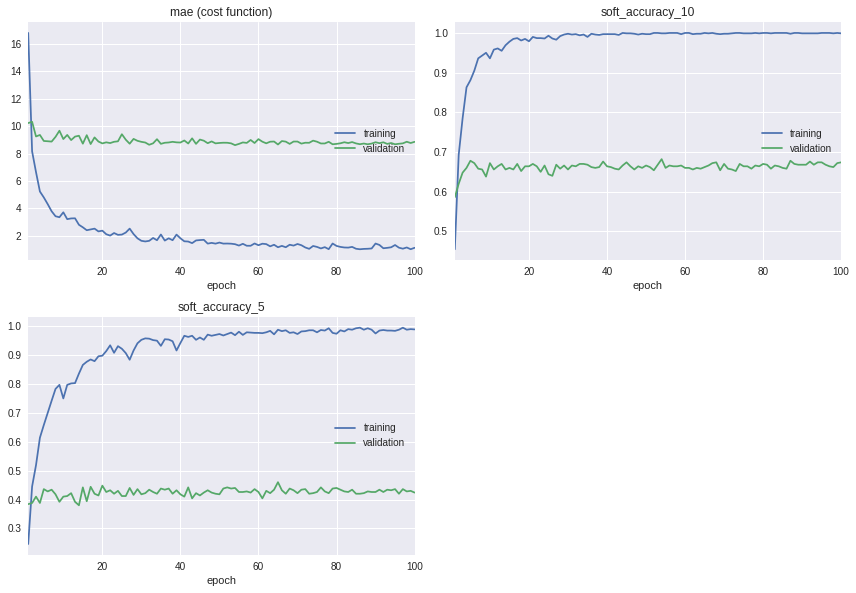

mae (cost function):
training   (min:    1.013, max:   16.797, cur:    1.119)
validation (min:    8.610, max:   10.314, cur:    8.851)

soft_accuracy_10:
training   (min:    0.455, max:    1.000, cur:    0.999)
validation (min:    0.586, max:    0.682, cur:    0.674)

soft_accuracy_5:
training   (min:    0.246, max:    0.995, cur:    0.989)
validation (min:    0.380, max:    0.460, cur:    0.424)


In [41]:
run_model(model)

In [42]:
evaluate_model(model)

1000/1000 [==============================] - 1s 694us/step
loss: 9.034910629272462
soft_accuracy_10: 0.677
soft_accuracy_5: 0.437


# Version 2

Let us add two batch normalization layers, and two dropout layers, see how they change the results.

In [43]:
def cnn_v2_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Dense(20, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v2_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v2_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 131072)            0         
_________________________________________________________________
batch_normalization_189 (Bat (None, 131072)            524288    
_________________________________________________________________
dropout_1 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)                2621460   
_________________________________________________________________
batch_normalization_190 (Bat (None, 20)                80        
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 21        
Total para

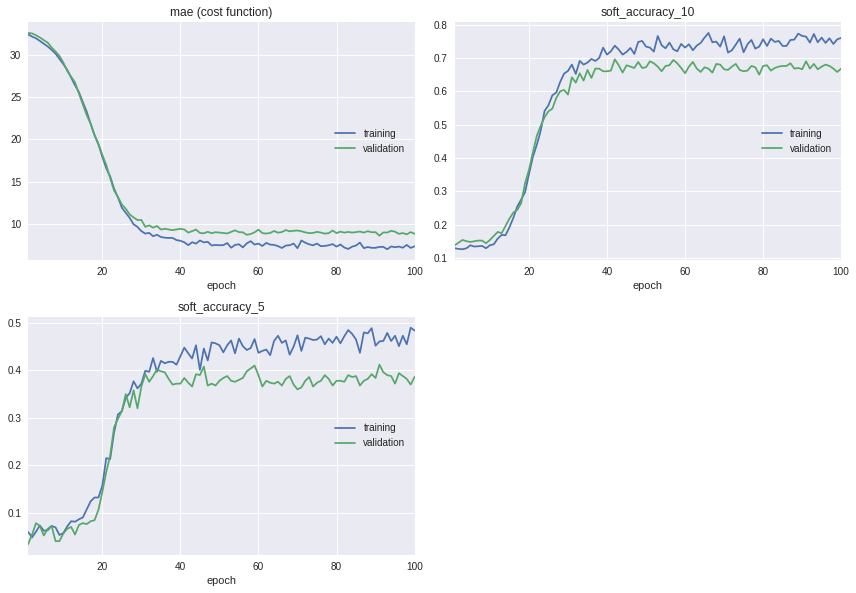

mae (cost function):
training   (min:    7.026, max:   32.404, cur:    7.367)
validation (min:    8.629, max:   32.574, cur:    8.855)

soft_accuracy_10:
training   (min:    0.126, max:    0.775, cur:    0.760)
validation (min:    0.138, max:    0.696, cur:    0.668)

soft_accuracy_5:
training   (min:    0.048, max:    0.490, cur:    0.484)
validation (min:    0.034, max:    0.412, cur:    0.386)


In [44]:
run_model(model)

In [45]:
evaluate_model(model)

1000/1000 [==============================] - 2s 2ms/step
loss: 8.963006973266602
soft_accuracy_10: 0.688
soft_accuracy_5: 0.423


# Version 3

In [46]:
def cnn_v3_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(20, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v3_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v3_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 131072)            0         
_________________________________________________________________
batch_normalization_191 (Bat (None, 131072)            524288    
_________________________________________________________________
dropout_3 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                2621460   
_________________________________________________________________
batch_normalization_192 (Bat (None, 20)                80        
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 21        
Total para

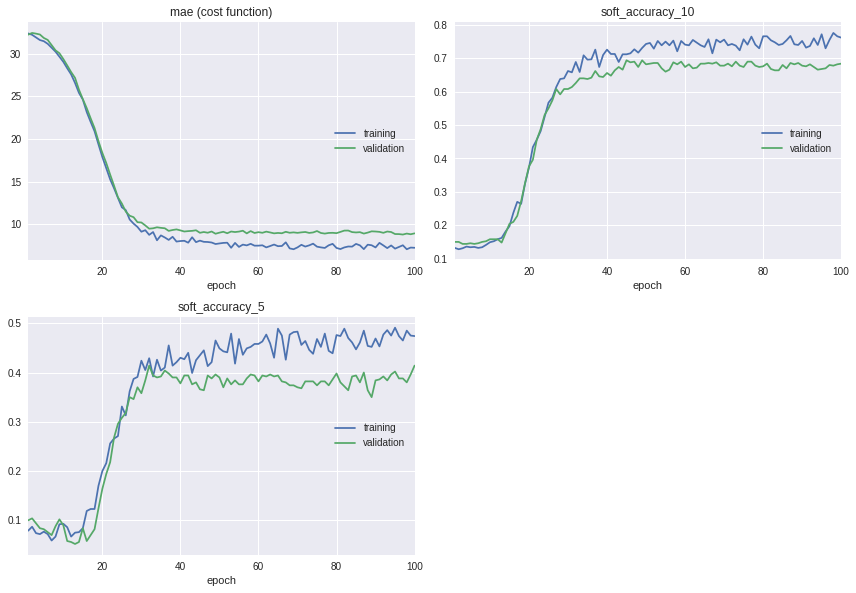

mae (cost function):
training   (min:    7.042, max:   32.394, cur:    7.214)
validation (min:    8.769, max:   32.452, cur:    8.907)

soft_accuracy_10:
training   (min:    0.128, max:    0.776, cur:    0.762)
validation (min:    0.144, max:    0.694, cur:    0.684)

soft_accuracy_5:
training   (min:    0.059, max:    0.491, cur:    0.474)
validation (min:    0.052, max:    0.414, cur:    0.414)


In [47]:
run_model(model)

In [48]:
evaluate_model(model)

1000/1000 [==============================] - 3s 3ms/step
loss: 9.088816513061523
soft_accuracy_10: 0.679
soft_accuracy_5: 0.415


# Version 4

In [49]:
def cnn_v4_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(20, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(1))
    adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mae', optimizer=adam, metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v4_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v4_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 131072)            0         
_________________________________________________________________
batch_normalization_193 (Bat (None, 131072)            524288    
_________________________________________________________________
dropout_5 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 20)                2621460   
_________________________________________________________________
batch_normalization_194 (Bat (None, 20)                80        
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 21        
Total para

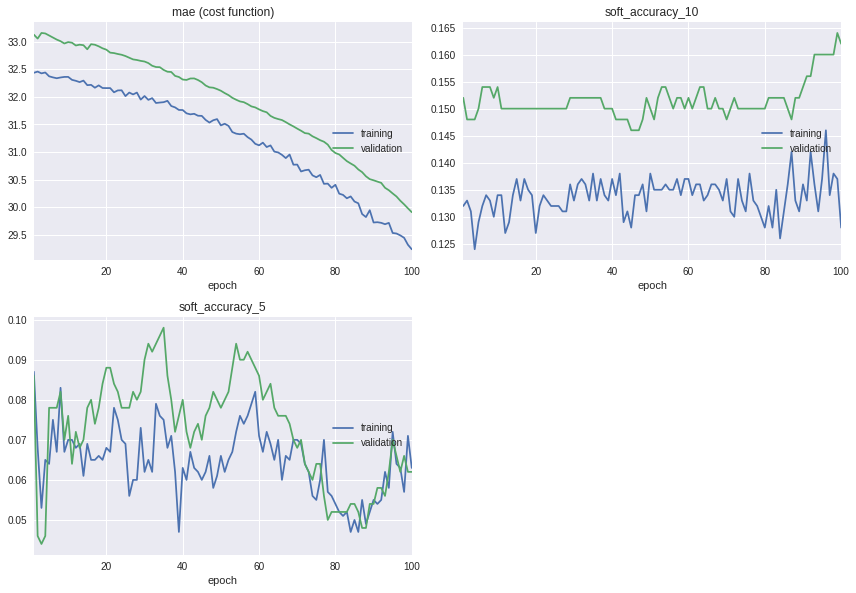

mae (cost function):
training   (min:   29.240, max:   32.458, cur:   29.240)
validation (min:   29.912, max:   33.157, cur:   29.912)

soft_accuracy_10:
training   (min:    0.124, max:    0.146, cur:    0.128)
validation (min:    0.146, max:    0.164, cur:    0.162)

soft_accuracy_5:
training   (min:    0.047, max:    0.087, cur:    0.063)
validation (min:    0.044, max:    0.098, cur:    0.062)


In [50]:
run_model(model)

In [51]:
evaluate_model(model)

1000/1000 [==============================] - 4s 4ms/step
loss: 31.483353088378905
soft_accuracy_10: 0.134
soft_accuracy_5: 0.04


# Version 5

In [52]:
def cnn_v5_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(20, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(1))
    adam = optimizers.Adam(lr=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=adam, metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v5_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v5_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 131072)            0         
_________________________________________________________________
batch_normalization_195 (Bat (None, 131072)            524288    
_________________________________________________________________
dropout_7 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 20)                2621460   
_________________________________________________________________
batch_normalization_196 (Bat (None, 20)                80        
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 21        
Total para

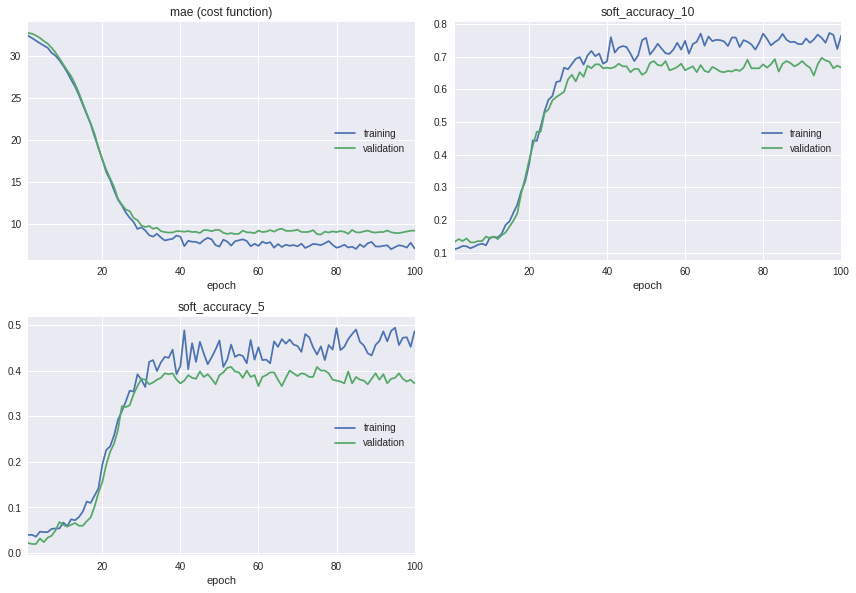

mae (cost function):
training   (min:    6.966, max:   32.434, cur:    7.068)
validation (min:    8.723, max:   32.770, cur:    9.191)

soft_accuracy_10:
training   (min:    0.111, max:    0.772, cur:    0.764)
validation (min:    0.132, max:    0.696, cur:    0.666)

soft_accuracy_5:
training   (min:    0.036, max:    0.494, cur:    0.486)
validation (min:    0.020, max:    0.408, cur:    0.372)


In [53]:
run_model(model)

In [54]:
evaluate_model(model)

1000/1000 [==============================] - 4s 4ms/step
loss: 9.361358978271484
soft_accuracy_10: 0.68
soft_accuracy_5: 0.421


# Version 6

In [55]:
def cnn_v6_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(20, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(1))
    adam = optimizers.Adam(lr=0.001, decay=1e-5)
    model.compile(loss=tilted_loss, optimizer=adam, metrics=['mae', soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v6_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v6_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 131072)            0         
_________________________________________________________________
batch_normalization_197 (Bat (None, 131072)            524288    
_________________________________________________________________
dropout_9 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 20)                2621460   
_________________________________________________________________
batch_normalization_198 (Bat (None, 20)                80        
_________________________________________________________________
dropout_10 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 21        
Total para

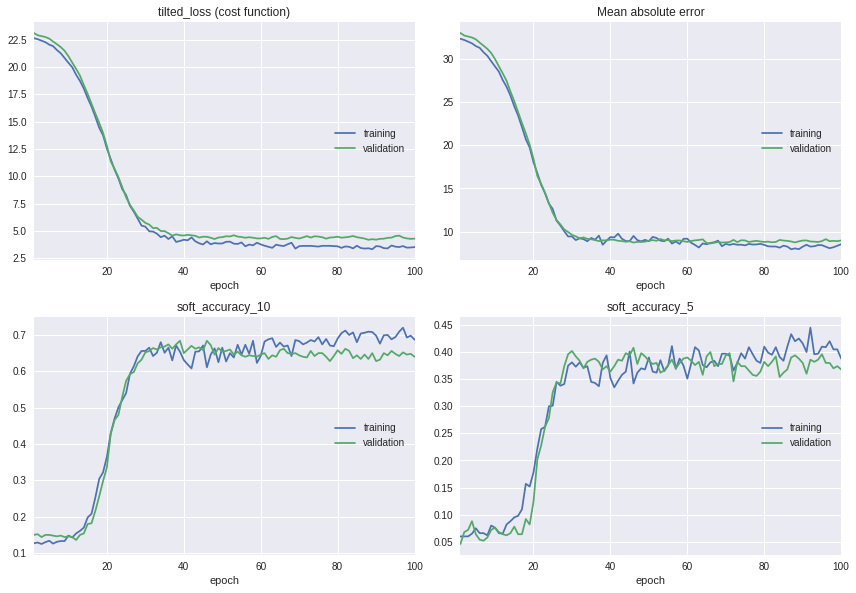

tilted_loss (cost function):
training   (min:    3.310, max:   22.661, cur:    3.506)
validation (min:    4.177, max:   23.135, cur:    4.282)

Mean absolute error:
training   (min:    7.942, max:   32.376, cur:    8.530)
validation (min:    8.615, max:   33.049, cur:    8.961)

soft_accuracy_10:
training   (min:    0.125, max:    0.720, cur:    0.687)
validation (min:    0.136, max:    0.684, cur:    0.640)

soft_accuracy_5:
training   (min:    0.060, max:    0.445, cur:    0.388)
validation (min:    0.046, max:    0.408, cur:    0.368)


In [56]:
run_model(model)

In [57]:
evaluate_model(model)

1000/1000 [==============================] - 3s 3ms/step
loss: 4.524332595825196
mean_absolute_error: 9.266937355041504
soft_accuracy_10: 0.644
soft_accuracy_5: 0.339


# Version 7


In [58]:
def cnn_v7_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(BatchNormalization())
    model.add(Dense(20, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v7_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v7_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 131072)            0         
_________________________________________________________________
batch_normalization_199 (Bat (None, 131072)            524288    
_________________________________________________________________
dense_23 (Dense)             (None, 20)                2621460   
_________________________________________________________________
batch_normalization_200 (Bat (None, 20)                80        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 21        
Total params: 3,145,849
Trainable params: 2,883,665
Non-trainable params: 262,184
_________________________________________________________________


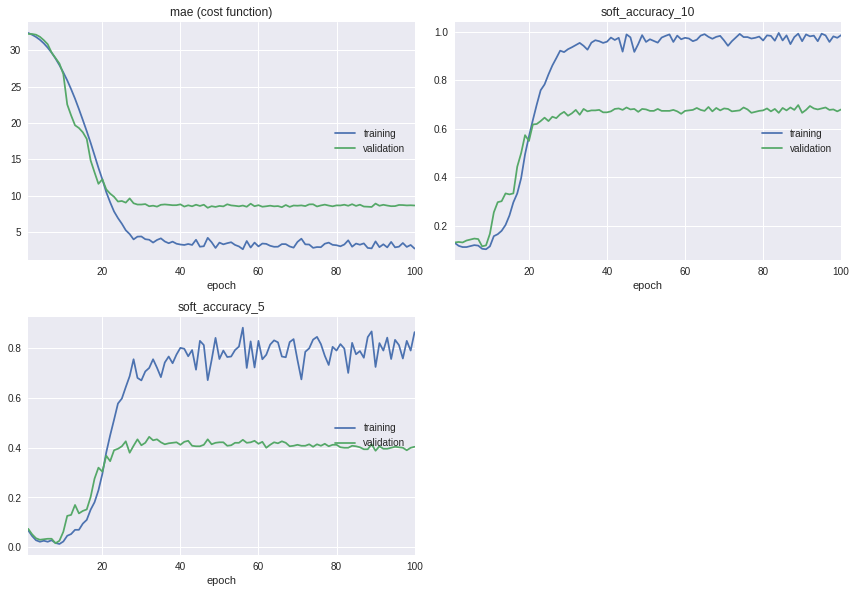

mae (cost function):
training   (min:    2.625, max:   32.371, cur:    2.720)
validation (min:    8.327, max:   32.241, cur:    8.643)

soft_accuracy_10:
training   (min:    0.104, max:    0.995, cur:    0.986)
validation (min:    0.116, max:    0.698, cur:    0.680)

soft_accuracy_5:
training   (min:    0.013, max:    0.883, cur:    0.865)
validation (min:    0.016, max:    0.444, cur:    0.404)


In [59]:
run_model(model)

In [60]:
evaluate_model(model)

1000/1000 [==============================] - 4s 4ms/step
loss: 8.787425971984863
soft_accuracy_10: 0.697
soft_accuracy_5: 0.412


# Version 8


In [61]:
def cnn_v8_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v8_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v8_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_25 (Dense)             (None, 20)                2621460   
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 21        
Total params: 2,621,481
Trainable params: 2,621,481
Non-trainable params: 0
_________________________________________________________________


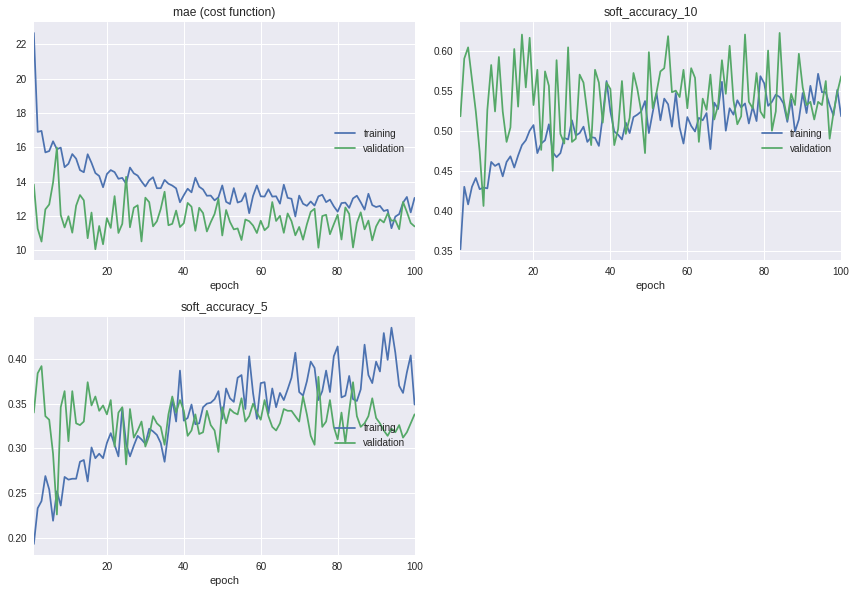

mae (cost function):
training   (min:   11.292, max:   22.659, cur:   13.056)
validation (min:   10.068, max:   15.986, cur:   11.398)

soft_accuracy_10:
training   (min:    0.352, max:    0.571, cur:    0.518)
validation (min:    0.406, max:    0.622, cur:    0.568)

soft_accuracy_5:
training   (min:    0.193, max:    0.435, cur:    0.349)
validation (min:    0.226, max:    0.392, cur:    0.338)


In [62]:
run_model(model)

In [63]:
evaluate_model(model)

1000/1000 [==============================] - 1s 909us/step
loss: 11.535682991027832
soft_accuracy_10: 0.587
soft_accuracy_5: 0.365


# Version 9


In [64]:
def cnn_v9_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(Dropout(.3))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v9_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v9_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 131072)            0         
_________________________________________________________________
dense_27 (Dense)             (None, 20)                2621460   
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 21        
Total params: 2,621,481
Trainable params: 2,621,481
Non-trainable params: 0
_________________________________________________________________


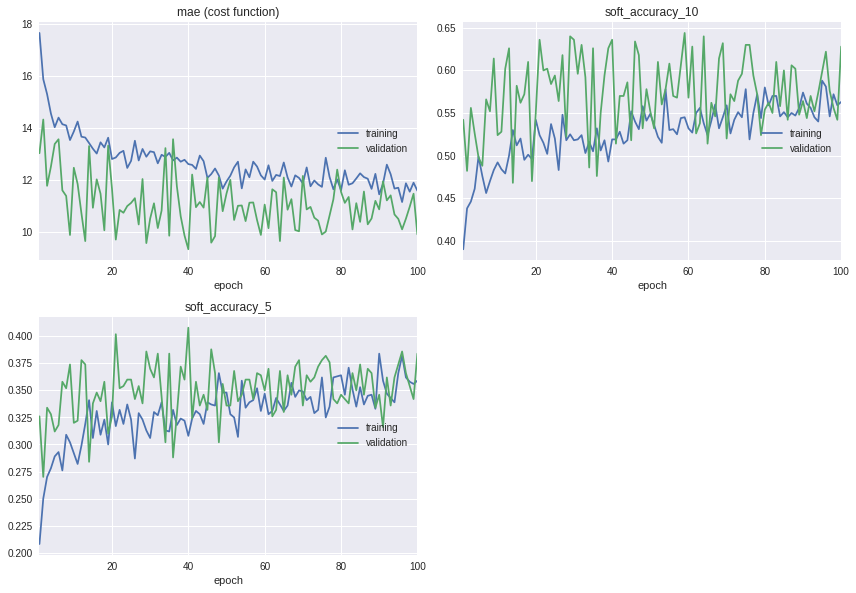

mae (cost function):
training   (min:   11.151, max:   17.665, cur:   11.588)
validation (min:    9.332, max:   14.330, cur:    9.906)

soft_accuracy_10:
training   (min:    0.390, max:    0.588, cur:    0.563)
validation (min:    0.468, max:    0.644, cur:    0.628)

soft_accuracy_5:
training   (min:    0.208, max:    0.384, cur:    0.359)
validation (min:    0.270, max:    0.408, cur:    0.384)


In [65]:
run_model(model)

In [66]:
evaluate_model(model)

1000/1000 [==============================] - 1s 1ms/step
loss: 10.158341537475586
soft_accuracy_10: 0.634
soft_accuracy_5: 0.399


# Version 10

In [67]:
def cnn_v10_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v10_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v10_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_29 (Dense)             (None, 50)                6553650   
_________________________________________________________________
dense_30 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 6,556,251
Trainable params: 6,556,251
Non-trainable params: 0
_________________________________________________________________


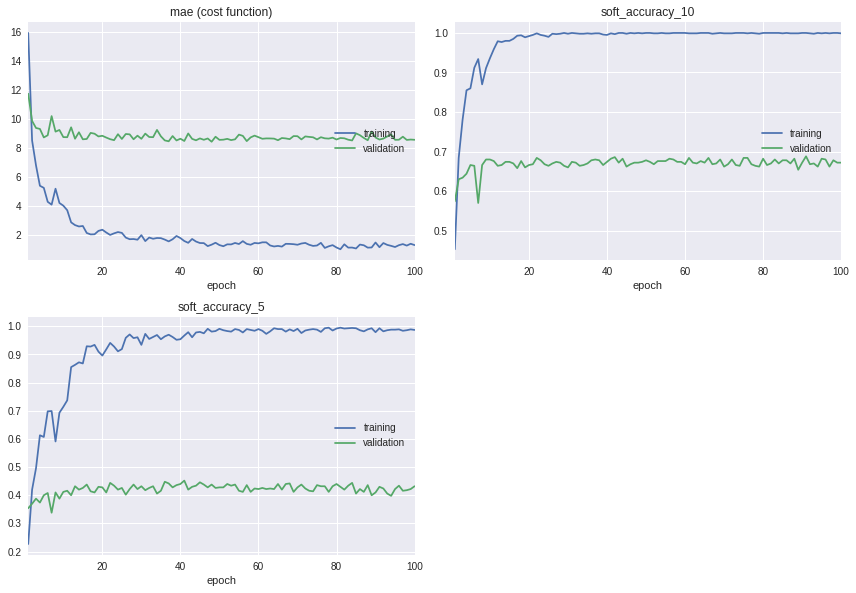

mae (cost function):
training   (min:    0.980, max:   15.944, cur:    1.269)
validation (min:    8.419, max:   11.738, cur:    8.552)

soft_accuracy_10:
training   (min:    0.453, max:    1.000, cur:    0.999)
validation (min:    0.570, max:    0.688, cur:    0.672)

soft_accuracy_5:
training   (min:    0.227, max:    0.995, cur:    0.987)
validation (min:    0.338, max:    0.452, cur:    0.432)


In [68]:
run_model(model)

In [69]:
evaluate_model(model)

1000/1000 [==============================] - 1s 1ms/step
loss: 8.883382553100587
soft_accuracy_10: 0.685
soft_accuracy_5: 0.408


# Verison 11

In [70]:
def cnn_v11_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v11_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v11_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                6553650   
_________________________________________________________________
dense_33 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_34 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 51        
Total params: 6,558,801
Trainable params: 6,558,801
Non-trainable params: 0
_________________________________________________________________


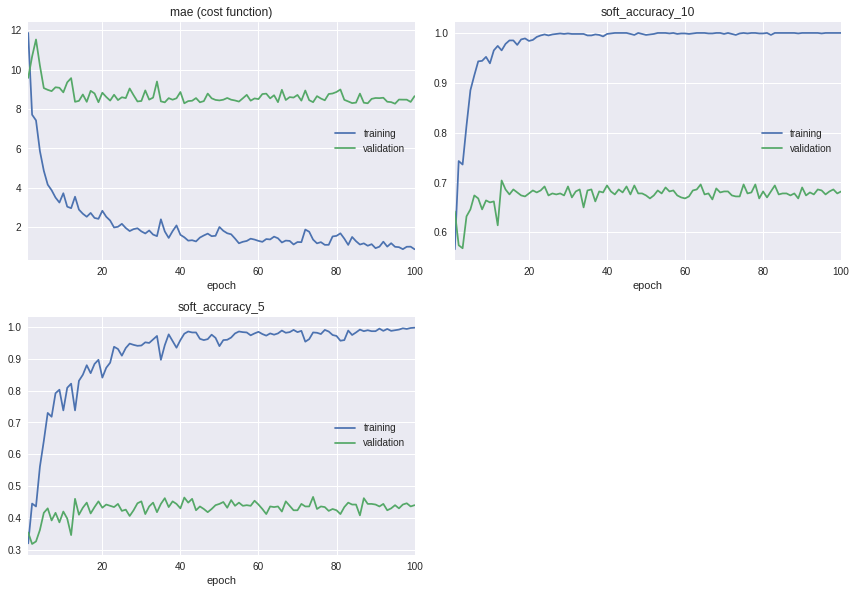

mae (cost function):
training   (min:    0.890, max:   11.854, cur:    0.890)
validation (min:    8.268, max:   11.522, cur:    8.651)

soft_accuracy_10:
training   (min:    0.566, max:    1.000, cur:    1.000)
validation (min:    0.568, max:    0.704, cur:    0.682)

soft_accuracy_5:
training   (min:    0.320, max:    0.998, cur:    0.998)
validation (min:    0.318, max:    0.466, cur:    0.440)


In [71]:
run_model(model)

In [72]:
evaluate_model(model)

1000/1000 [==============================] - 1s 1ms/step
loss: 8.861557861328125
soft_accuracy_10: 0.685
soft_accuracy_5: 0.454


# Verison 12

In [73]:
def cnn_v12_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(Dropout(.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v12_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v12_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 131072)            0         
_________________________________________________________________
dense_36 (Dense)             (None, 50)                6553650   
_________________________________________________________________
dense_37 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 101       
Total params: 6,558,851
Trainable params: 6,558,851
Non-trainable params: 0
_________________________________________________________________


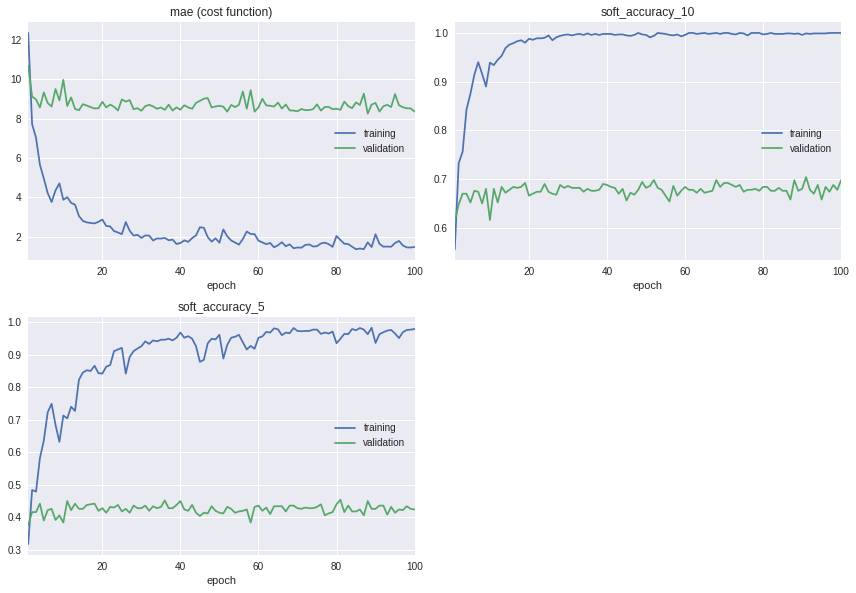

mae (cost function):
training   (min:    1.357, max:   12.359, cur:    1.471)
validation (min:    8.254, max:   10.689, cur:    8.362)

soft_accuracy_10:
training   (min:    0.556, max:    1.000, cur:    1.000)
validation (min:    0.614, max:    0.704, cur:    0.698)

soft_accuracy_5:
training   (min:    0.318, max:    0.983, cur:    0.979)
validation (min:    0.376, max:    0.454, cur:    0.424)


In [74]:
run_model(model)

In [75]:
evaluate_model(model)

1000/1000 [==============================] - 1s 1ms/step
loss: 8.772707954406739
soft_accuracy_10: 0.69
soft_accuracy_5: 0.42


# Verison 13

In [76]:
def cnn_v13_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(Dropout(.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='nadam', metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v13_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v13_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 131072)            0         
_________________________________________________________________
dense_39 (Dense)             (None, 50)                6553650   
_________________________________________________________________
dense_40 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 101       
Total params: 6,558,851
Trainable params: 6,558,851
Non-trainable params: 0
_________________________________________________________________


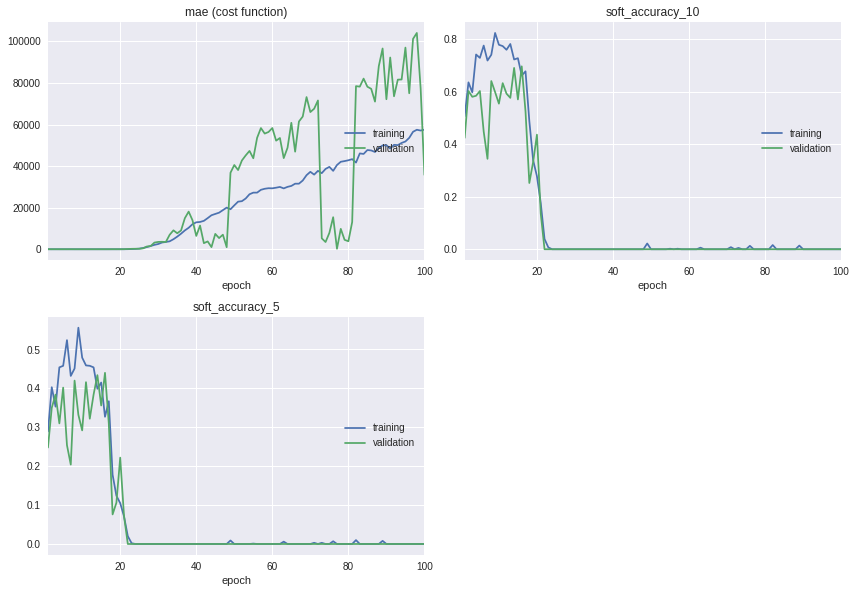

mae (cost function):
training   (min:    5.777, max: 57493.082, cur: 57493.082)
validation (min:    8.593, max: 104028.151, cur: 35776.749)

soft_accuracy_10:
training   (min:    0.000, max:    0.823, cur:    0.000)
validation (min:    0.000, max:    0.696, cur:    0.000)

soft_accuracy_5:
training   (min:    0.000, max:    0.556, cur:    0.000)
validation (min:    0.000, max:    0.440, cur:    0.000)


In [77]:
run_model(model)

In [78]:
evaluate_model(model)

1000/1000 [==============================] - 1s 1ms/step
loss: 35251.916125
soft_accuracy_10: 0.0
soft_accuracy_5: 0.0


# Verison 14

In [79]:
def cnn_v14_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.add(Dropout(.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adadelta', metrics=[soft_accuracy_10, soft_accuracy_5])
    return model

model = cnn_v14_model(train_data_features.shape)      
model.summary()

checkpointer = ModelCheckpoint(filepath=features_folder + 'v14_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 131072)            0         
_________________________________________________________________
dense_42 (Dense)             (None, 50)                6553650   
_________________________________________________________________
dense_43 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 101       
Total params: 6,558,851
Trainable params: 6,558,851
Non-trainable params: 0
_________________________________________________________________


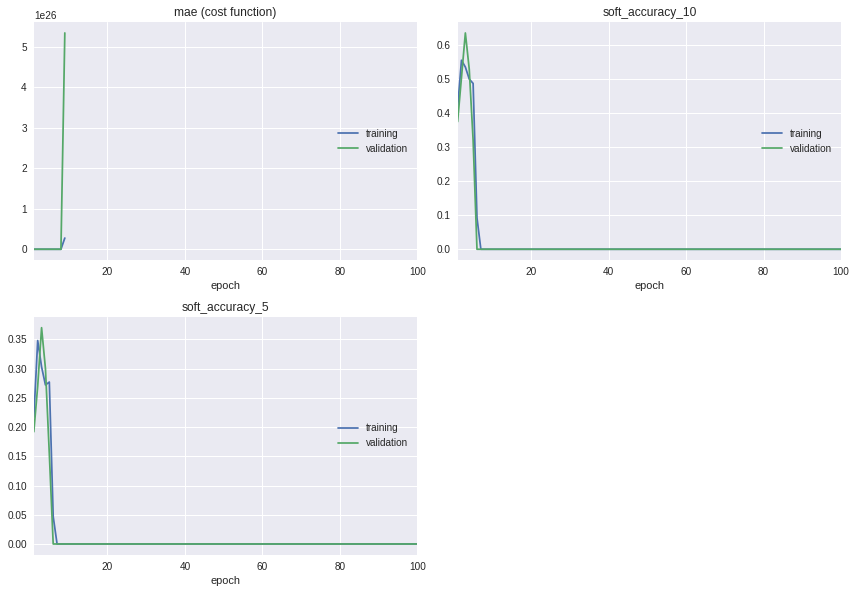

mae (cost function):
training   (min:   11.265, max: 27673117435513301278654464.000, cur:      nan)
validation (min:   10.069, max: 533693907616419384613928960.000, cur:      nan)

soft_accuracy_10:
training   (min:    0.000, max:    0.554, cur:    0.000)
validation (min:    0.000, max:    0.634, cur:    0.000)

soft_accuracy_5:
training   (min:    0.000, max:    0.348, cur:    0.000)
validation (min:    0.000, max:    0.370, cur:    0.000)


In [80]:
run_model(model)

In [81]:
evaluate_model(model)

1000/1000 [==============================] - 1s 1ms/step
loss: nan
soft_accuracy_10: 0.0
soft_accuracy_5: 0.0
